In [1]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours as COUNTOURS
from modules.utils import *
import numpy as np
import pytesseract
import argparse
import imutils
import cv2
import re
from PIL import Image
import sys

In [2]:
# functions


def read_file(path, isModelAnswer=True):
    """
    Reads both of the answer key file and the grades key file.
    Arguments:
        path: a string
        isModelAnswer: an optional boolean
    Returns:
        The object with the info from the files.
    """
    # open the file
    input_file = open(path, "r")
    ANSWER_KEY = {}

    # Checking if the file readable
    if (not input_file.readable()):
        raise ("This input file is not readable.")

    # read the content
    answers_list = input_file.read().splitlines()

    # filling the result object
    for index in range(len(answers_list)):
        ANSWER_KEY[index] = ord(answers_list[index].upper(
        )) - 65 if isModelAnswer else int(answers_list[index])

    # close the file
    input_file.close()
    return ANSWER_KEY


def check_bubble_existence(gray_image):
    """
    Checks whether the given image has bubbles or not.
    Arguments:
        gray_image: Image
    Returns:
        1- The number of bubbles, if found.
        2- The coordinates of the last found bubble.
    """
    # apply Otsu's thresholding method to binarize the warped piece of paper
    thresh = cv2.threshold(
        gray_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    kernal = np.ones((2, 2), np.uint8)
    thresh_closed = cv.morphologyEx(
        thresh, cv.MORPH_CLOSE, kernal, iterations=1)
    # find contours in the thresholded image, then
    contours = cv2.findContours(
        thresh_closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # initialize the list of contours that correspond to questions/bubbles
    questionCnts = []
    position_of_first_bubble = sys.maxsize  # MAX
    x_position = 0
    space_between_two_bubbles = 0
    bubble_info = []
    # loop over the contours
    for cnt in contours:
        # compute the bounding box of the contour, then use the bounding box to derive the aspect ratio
        (x, y, w, h) = cv2.boundingRect(cnt)
        ar = w / float(h)

        # in order to label the contour as a question, region should be sufficiently wide, sufficiently tall, and
        # have an aspect ratio approximately equal to 1
        if w >= 13 and h >= 11 and ar >= 0.7 and ar <= 1.2:
            show_images([gray_image, thresh_closed], [
                        'Bubble Found', 'After closing'])
            bubble_info = [x, y, w, h]
            questionCnts.append(cnt)
            position_of_first_bubble = min(position_of_first_bubble, x)
            space_between_two_bubbles = abs(x - x_position)
            x_position = x
    count_of_bubbles = len(questionCnts)
    return [count_of_bubbles, bubble_info]


def check_row_validity(bubbles_positions, window_height):
    """
    Confirms that the given image has one row .
    Arguments:
        bubbles_positions: Array
        window_height: Integer
    Returns:
        True if the image has only one row, False otherwise
    """
    length = len(bubbles_positions)
    if (length > 0):
        first_bubble = bubbles_positions[0]
        last_bubble = bubbles_positions[length - 1]
        if (abs(first_bubble - last_bubble) >= 10):
            return False
        else:
            return True
    else:
        return False


def get_num_of_row_bubbles(gray_image):
    """
    Finds the bubbles in the given image.
    Arguments:
        gray_image: Image (grayscale)
    Returns:
        number of bubbles in the passed image
    """
    # apply Otsu's thresholding method to binarize the warped piece of paper
    thresh = cv2.threshold(
        gray_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    kernal = np.ones((2, 2), np.uint8)
    thresh_closed = cv.morphologyEx(
        thresh, cv.MORPH_CLOSE, kernal, iterations=2)
    show_images([gray_image, thresh_closed], ['One Row Gray', 'After Closing'])
    # find contours in the thresholded image
    contours = cv2.findContours(
        thresh_closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # initialize the list of contours that correspond to questions/bubbles
    questionCnts = []
    y_positions = []
    position_of_first_bubble = sys.maxsize  # MAX INTEGER VALUE
    x_positions = []
    space_between_two_bubbles = 0
    # loop over the contours
    for cnt in contours:
        # compute the bounding box of the contour, then use the bounding box to derive the aspect ratio
        (x, y, w, h) = cv2.boundingRect(cnt)
        ar = w / float(h)
        # in order to label the contour as a question, region should be sufficiently wide, sufficiently tall, and
        # have an aspect ratio approximately equal to 1
        if w >= 13 and h >= 11 and ar >= 0.7 and ar <= 1.2:
            questionCnts.append(cnt)
            y_positions.append(y)
            position_of_first_bubble = min(position_of_first_bubble, x)
            x_positions.append(x)

            x_position = x
    count_of_bubbles = len(questionCnts)
    x_positions = sorted(x_positions, reverse=False)
    y_positions = sorted(y_positions, reverse=False)
    space_between_two_bubbles = abs(x_positions[0] - x_positions[1])
    bubbles_area_width = x_positions[len(x_positions) - 1] - x_positions[0]
    return [count_of_bubbles, position_of_first_bubble, space_between_two_bubbles, y_positions, x_positions]


def detect_one_row(img, window_height=60):
    """
    Tries to crop one row from the image of the bubble sheet.
    Arguments:
        img: Image
        window_height: Integer
    Returns:
        1- the found row.
        2- number of bubbles in that row.
    """

    height = img.shape[0]
    width = img.shape[1]
    step_width = window_height
    finished = False
    bubbles_counter = 0
    start_position = (height // 4) - 15

    while not finished:
        cropped_row = img[start_position: start_position + step_width, 0:width]
        start_position += step_width
        [found_bubble, position_of_first_bubble, space_between_two_bubbles,
            y_positions, x_positions] = get_num_of_row_bubbles(cropped_row)
        if (found_bubble > 0):
            if (check_row_validity(y_positions, step_width)):
                row_bubbles_count = found_bubble
                finished = True
            else:
                step_width -= 10
    return [cropped_row, row_bubbles_count, position_of_first_bubble, space_between_two_bubbles, x_positions]


def check_bubbles_similarity(first, second):
    """
    Confirms that the two passed bubble are similar
    Arguments:
        first:  Image
        second: Image
    Returns:
        True if they are similar, False otherwise
    """
    #     check y-coordinate
    if (abs(first[1] - second[1]) > 5):
        return False
    #     check width
    if (abs(first[2] - second[2]) > 5):
        return False
    #     check height
    if (abs(first[3] - second[3]) > 5):
        return False
    return True


def get_answers_count(img, position_of_first_bubble=0, space_between_two_bubbles=20):
    """
    Detects the number of answers in each question
    Arguments:
        img: Image
        position_of_first_bubble:  Integer
        space_between_two_bubbles: Integer
    Returns:
        The answers count for each answer.
    """
    height = img.shape[0]
    width = img.shape[1]
    step_width = space_between_two_bubbles

    started = False
    finished = False
    bubbles_counter = 0
    start_position = position_of_first_bubble - 2

    # First bubble will always be detected.
    bubble_cropped = img[0:height, start_position:start_position+step_width]
    [bubbles_counter, old_bubble_info] = check_bubble_existence(bubble_cropped)
    start_position += step_width
    while not finished:
        bubble_cropped = img[0:height,
                             start_position:start_position+step_width]

        start_position += step_width
        [found_bubble, new_bubble_info] = check_bubble_existence(
            bubble_cropped)
        if (found_bubble > 0):
            # checking whether it's similar to the last bubbles or not ( it may not be a bubble )
            if (check_bubbles_similarity(old_bubble_info, new_bubble_info)):
                bubbles_counter += found_bubble
                old_bubble_info = new_bubble_info
            else:
                print('bubble is not similar to the last one')
                finished = True
        else:
            finished = True

    return bubbles_counter


def resize_image(img):
    """
    Resizes the given image near to 800 * 600
    Arguments:
        img: Image
    Returns:
        The resized image.
    """
    height = img.shape[0]
    width = img.shape[1]

    if (height > 800):
        ratio = height / 800
        new_height = round(height / ratio)
        new_width = round(width / ratio)
        resized_image = cv2.resize(img, (new_width, new_height))
        return resized_image
    else:
        return img


def crop_image_vertically_into_n_sections(img, num_of_sections, x_positions):
    """
    Crops the given image vertically into n equal sections.
    Arguments:
        img: Image
        num_of_sections: Integer
    Returns:
        The cropped sections.
    """
    height = img.shape[0]
    width = img.shape[1]

    cropped_row = img[0:height, 0:width]
    new_width = width // num_of_sections
    start = 0

    results = []
    positions = np.copy(x_positions)
    groups = np.array_split(positions, num_of_sections)
    bubble_width = abs(positions[0] - positions[1])
    for i in range(num_of_sections):
        start_width = groups[i][0] - 10
        end_width = groups[i][len(groups[i]) - 1] + bubble_width
        results.append(img[0:height, start_width:end_width])

    for i in range(len(results)):
        show_images([results[i]], ["Section {:d}".format(i+1)])

    return results


def removeUnwantedContours(contours, contours_y_coordinates, question_answers_count):
    first_group_info = contours_y_coordinates[0:question_answers_count]
    last_group_info = contours_y_coordinates[len(
        contours) - question_answers_count:len(contours)]

    if (abs(first_group_info[0] - first_group_info[question_answers_count - 1]) > 5):
        contours.pop(0)

    if (abs(last_group_info[0] - last_group_info[question_answers_count - 1]) > 5):
        removed = contours.pop(len(contours) - 1)

    return
# end functions



In [8]:
def getId(image):
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)
    kernal = np.ones((3, 3), np.uint8)
    after_dilation = cv2.dilate(edged, kernal, iterations=2)
    
    # find contours in the edged image
    contours = cv2.findContours(after_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    idBox = None

    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    # ensure that at least one contour was found
    if len(contours) > 0:
        # sort the contours according to their size in descending order
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        # loop over the sorted contours
        for cnt in contours:
            # approximate the contour
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
            # if our approximated contour has four points, then we sucessfully found the box
            if len(approx) == 4:
                idBox = approx
                break

    # ensure that at least one contour was found
    box = four_point_transform(image, idBox.reshape(4, 2))
    show_images[box, "ID Box"]
    roi = np.copy(box)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    border = cv2.copyMakeBorder(roi,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
    resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    dilation = cv2.dilate(resizing, kernel,iterations=1)
    erosion = cv2.erode(dilation, kernel,iterations=2)
    img3 = cv2.cvtColor(erosion, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(img3, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]
    out = pytesseract.image_to_string(thresh,config="--psm 13")
    out = int(re.search(r'\d+', out).group())   # return the integer value found in the box
    return out

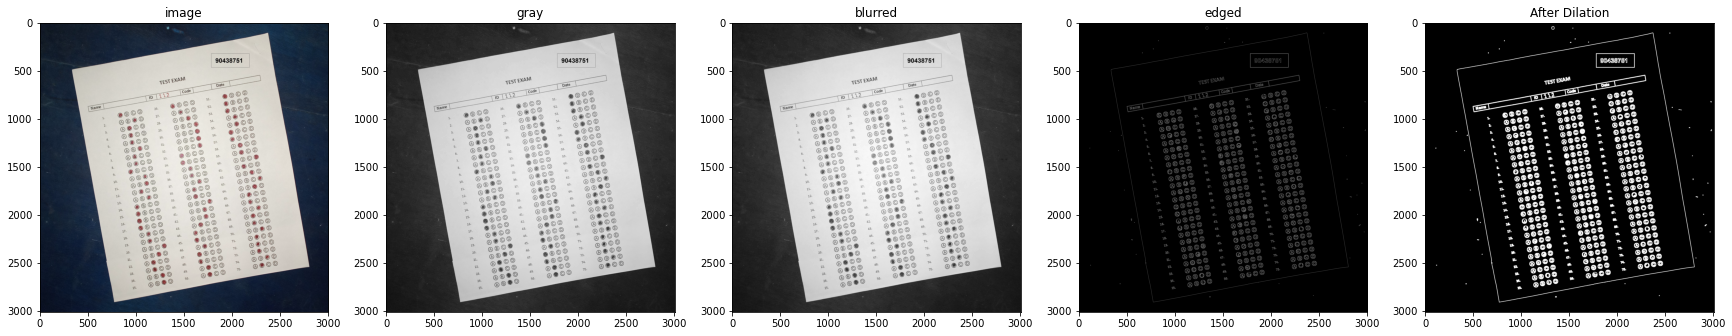

 sudent_id  90438751


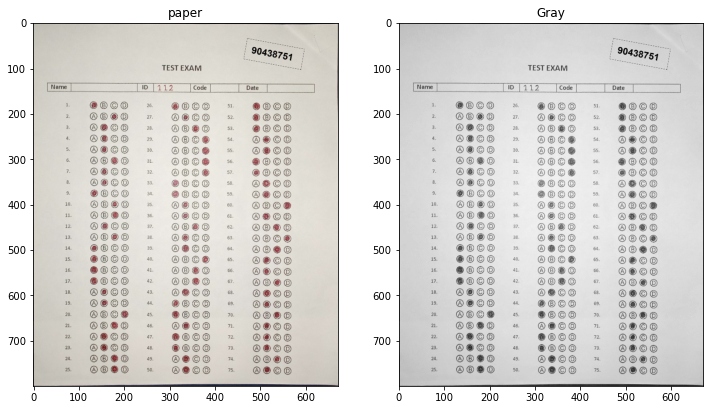

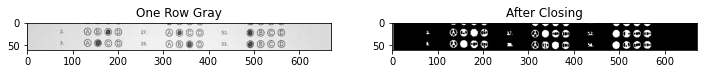

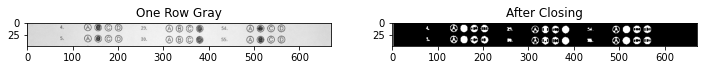

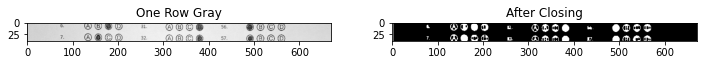

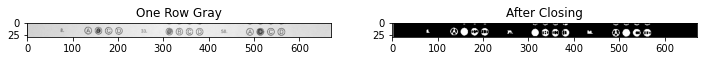

bubbles in each row =  12


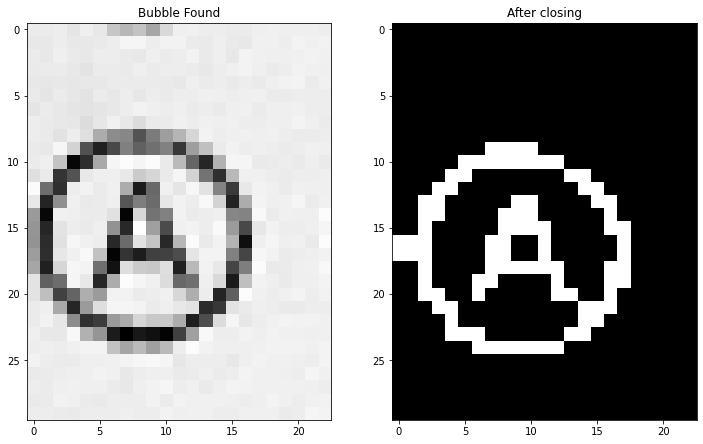

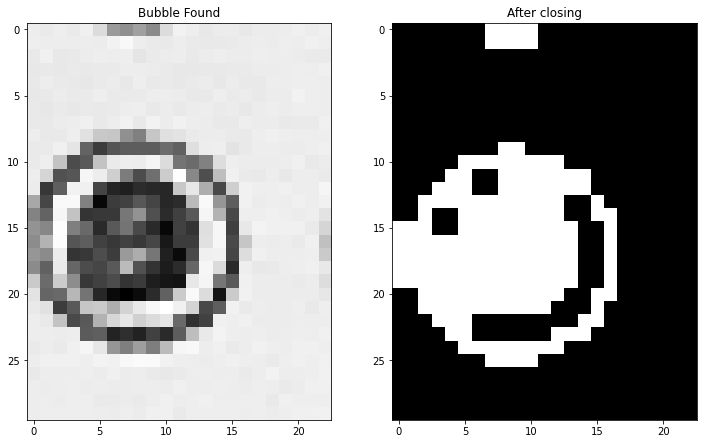

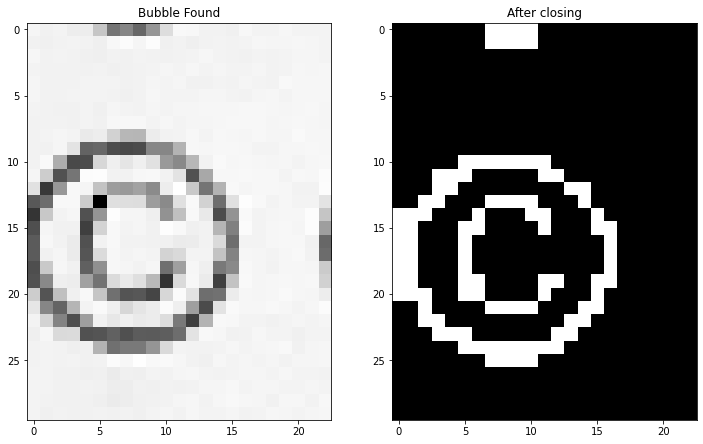

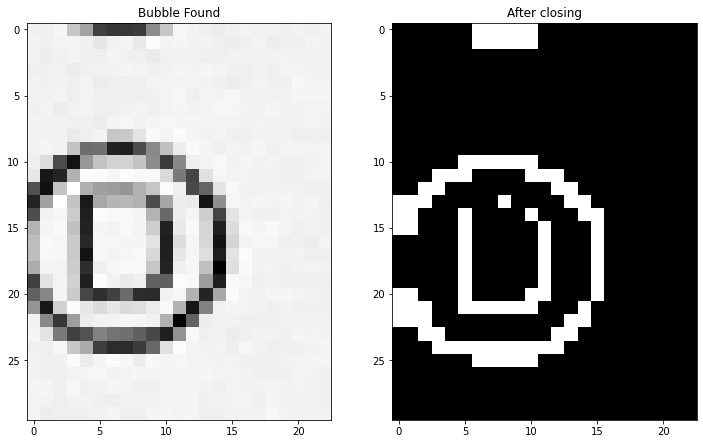

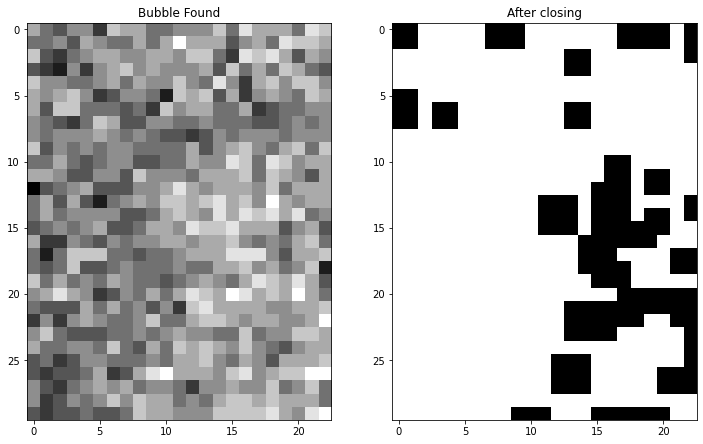

bubble is not similar to the last one
answers for each question =  4
num_of_sections 3


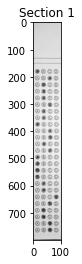

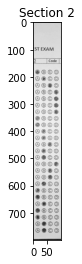

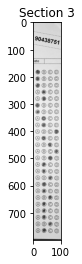

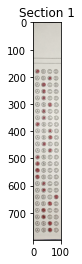

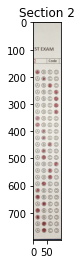

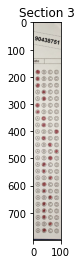

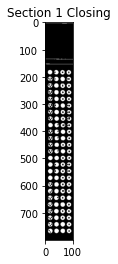

found  100  bubbles


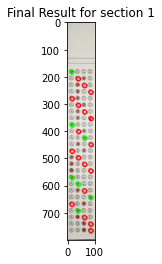

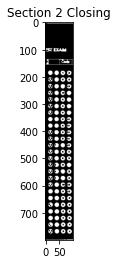

found  100  bubbles


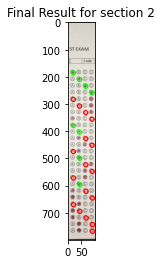

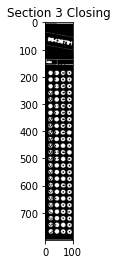

found  100  bubbles


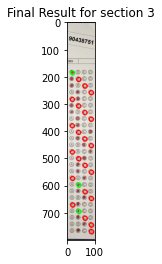

final_answers :  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


True

In [9]:
    answers_key_path = "../Data set/bubble sheet/2/answers.txt"
    grades_key_path = "../Data set/bubble sheet/2/grades.txt"
    excel_file_path = "../Data set/bubble sheet/file.xlsx"
    image_path = "../Data set/bubble sheet/2/2.jpg"


    # define the answer key which maps the question number to the correct answer
    ANSWER_KEY = read_file(answers_key_path)
    GRADES_KEY = read_file(grades_key_path, False)

    # load the image, convert it to grayscale, blur it slightly, then find edges
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)
    kernal = np.ones((3, 3), np.uint8)
    after_dilation = cv2.dilate(edged, kernal, iterations=2)

    show_images([image, gray, blurred, edged, after_dilation], [
                    "image", "gray", "blurred", "edged", "After Dilation"])

    # find contours in the edged image
    contours = cv2.findContours(
        after_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # initialize the contour that corresponds to the document
    docCnt = None

    # ensure that at least one contour was found
    if len(contours) > 0:
        # sort the contours according to their size in descending order
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        # loop over the sorted contours
        for cnt in contours:
            # approximate the contour
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

            # if our approximated contour has four points, then we sucessfully found the paper
            if len(approx) == 4:
                docCnt = approx
                break
    # apply a four point perspective transform to both the original image and grayscale image to obtain a top-down
    # birds eye view of the paper
    paper = four_point_transform(image, docCnt.reshape(4, 2))
    warped = four_point_transform(gray, docCnt.reshape(4, 2))
    resized_paper = resize_image(paper)
    resized_warped = resize_image(warped)
    
    student_id = getId(paper)
    print(' sudent_id ' , student_id)
    show_images([resized_paper, resized_warped], ["paper", "Gray"])

    [row, row_bubbles_count, position_of_first_bubble,
        space_between_two_bubbles, x_positions] = detect_one_row(resized_warped)
    print('bubbles in each row = ', row_bubbles_count)
    question_answers_count = get_answers_count(
        row, position_of_first_bubble, space_between_two_bubbles)
    print('answers for each question = ', question_answers_count)

    num_of_sections = row_bubbles_count // question_answers_count
    print('num_of_sections', num_of_sections)

    sections_gray = crop_image_vertically_into_n_sections(
        resized_warped, num_of_sections, x_positions)
    sections_paper = crop_image_vertically_into_n_sections(
        resized_paper, num_of_sections, x_positions)

    # apply Otsu's thresholding method to binarize the warped piece of paper
    final_answers = []
    final_grade = 0
    question_number = -1
    for index in range(len(sections_gray)):
        thresh = cv2.threshold(
            sections_gray[index], 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        kernal = np.ones((2, 2), np.uint8)
        thresh_closed = cv.morphologyEx(
            thresh, cv.MORPH_CLOSE, kernal, iterations=3)

        # find contours in the thresholded image, then
        show_images([thresh_closed], ["Section {:d} Closing".format(index+1)])
        contours = cv2.findContours(
            thresh_closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)

        # initialize the list of contours that correspond to questions/bubbles
        questionCnts = []
        contours_info = []
        # loop over the contours
        for cnt in contours:
            # compute the bounding box of the contour, then use the bounding box to derive the aspect ratio
            (x, y, w, h) = cv2.boundingRect(cnt)
            ar = w / float(h)
            # in order to label the contour as a question, region should be sufficiently wide, sufficiently tall, and
            # have an aspect ratio approximately equal to 1
            if (w >= 13 and w <= 25) and h >= 11 and ar >= 0.7 and ar <= 1.2:
                questionCnts.append(cnt)
                contours_info.append(y)
        removeUnwantedContours(
            questionCnts, contours_info, question_answers_count)
        print('found ', len(questionCnts), ' bubbles')
        # sort the question contours top-to-bottom, then initialize
        # the total number of correct answers
        questionCnts = COUNTOURS.sort_contours(
            questionCnts, method="top-to-bottom")[0]
        correct = 0
        # each question has n possible answers, to loop over the
        # question in batches of n

        for (q, i) in enumerate(np.arange(0, len(questionCnts), question_answers_count)):
            # sort the contours for the current question from
            # left to right, then initialize the index of the
            # bubbled answer
            cnts = COUNTOURS.sort_contours(
                questionCnts[i:i + question_answers_count])[0]

            question_number += 1
            bubbled = None

            # loop over the sorted contours
            for (iterator, c) in enumerate(cnts):
                # construct a mask that reveals only the current "bubble" for the question
                mask = np.zeros(thresh.shape, dtype="uint8")
                cv2.drawContours(mask, [c], -1, 255, -1)
                (x, y, w, h) = cv2.boundingRect(cnt)

                # apply the mask to the thresholded image, then
                # count the number of non-zero pixels in the
                # bubble area
                mask = cv2.bitwise_and(thresh, thresh, mask=mask)
                total = cv2.countNonZero(mask)
                # if the current total has a larger number of total
                # non-zero pixels, then we are examining the currently
                # bubbled-in answer
                if bubbled is None or total > bubbled[0]:
                    bubbled = (total, iterator)

            # initialize the contour color and the index of the
            # *correct* answer
            color = (255, 0, 0)
            k = ANSWER_KEY[question_number]
            # check to see if the bubbled answer is correct
            if k == bubbled[1]:
                color = (0, 255, 0)
                correct += 1
                final_answers.append(1)
                final_grade += GRADES_KEY[question_number]
            else:
                final_answers.append(0)
        #     draw the outline of the correct answer on the test
            cv2.drawContours(sections_paper[index], [cnts[k]], -1, color, 3)
        show_images([sections_paper[index]], [
                    "Final Result for section {:d}".format(index + 1)])
    print('final_answers : ', final_answers)
    # write the results in the excel sheet
    fill_grades(excel_file_path, student_id, final_answers)